In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import utils as ut
import m_models as mm
import os
from tqdm import tqdm_notebook as tqdm

import pylab

import statsmodels.api as sm

import scipy.stats as sps
from scipy.optimize import minimize_scalar as minimize_scalar

import pickle

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']= 36
plt.rcParams['axes.labelsize']= 40
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

---
Фиксируем константы

In [3]:
n = 4
M = 1000
sigma = 1

bootstrap_num_iter = 50

---
Генерируем выборку

In [4]:
w = sps.uniform().rvs(n)

X = sps.norm(loc=0, scale=1).rvs(size=(M, n))
y = X @ w + sps.norm(loc=0, scale=sigma).rvs(size=M)

In [5]:
statmodel = ut.define_model(y)

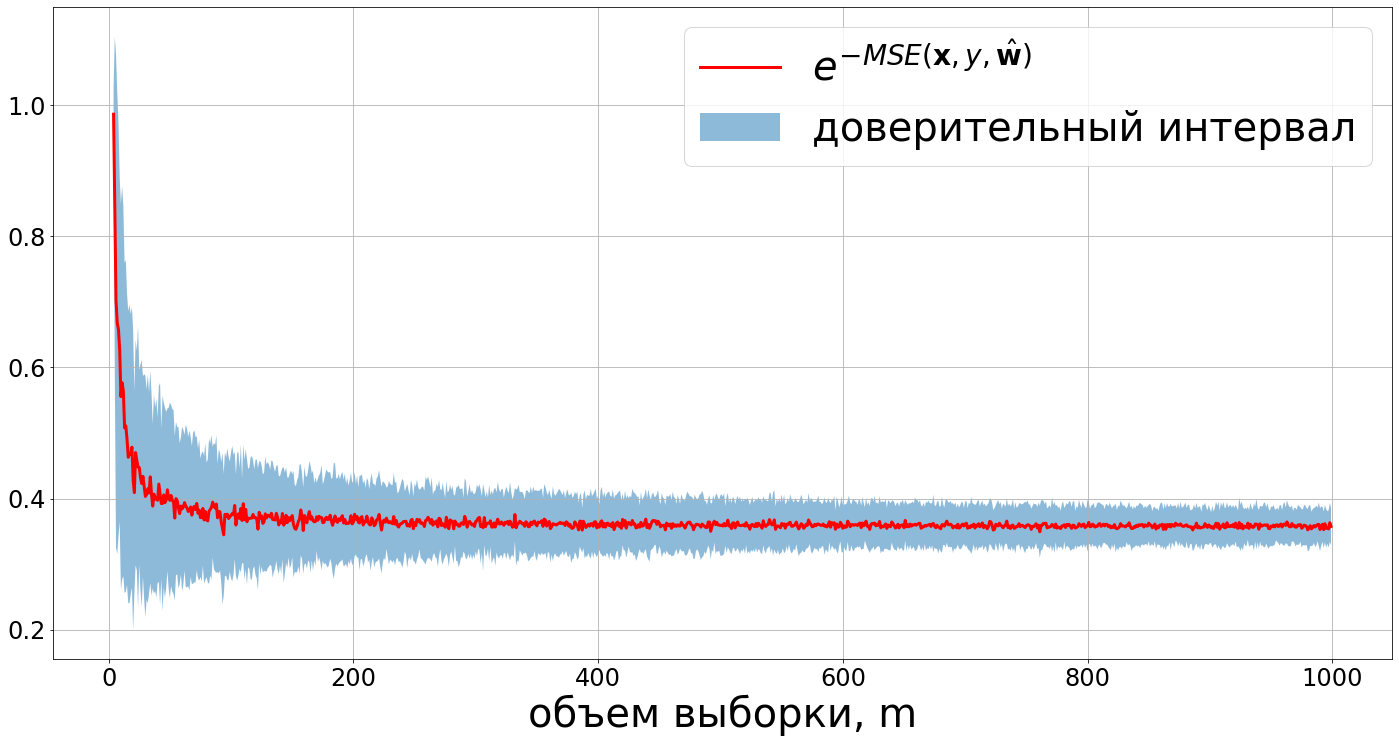

In [6]:
S = []
std = []

for m_0 in tqdm(range(4, M)):
    
    mse = []
    
    for i in range(bootstrap_num_iter):
        
        idx = np.random.choice(M, size=m_0)
        
        X_cur = X[idx]
        y_cur = y[idx]
        
        w_hat = ut.get_params(X_cur, y_cur)
        mse.append(np.exp(-np.mean((X_cur @ w_hat - y_cur) ** 2)))
        
    S.append(np.mean(mse))
    std.append(np.std(mse))
    
S = np.asarray(S)
std = np.asarray(std)
    
plt.plot(np.arange(4, M), S, color='red', label='$e^{-MSE(\mathbf{x}, y, \hat{\mathbf{w}})}$')
plt.fill_between(np.arange(4, M), sps.norm(loc=S, scale=std).ppf(0.05), sps.norm(loc=S, scale=std).ppf(0.95),
                 alpha=0.5, label='доверительный интервал')

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid()
plt.savefig('../data/pics/synthetic_S.pdf', format='pdf')
plt.show()

---
Посчитаем ковариационную матрицу вектора параметров

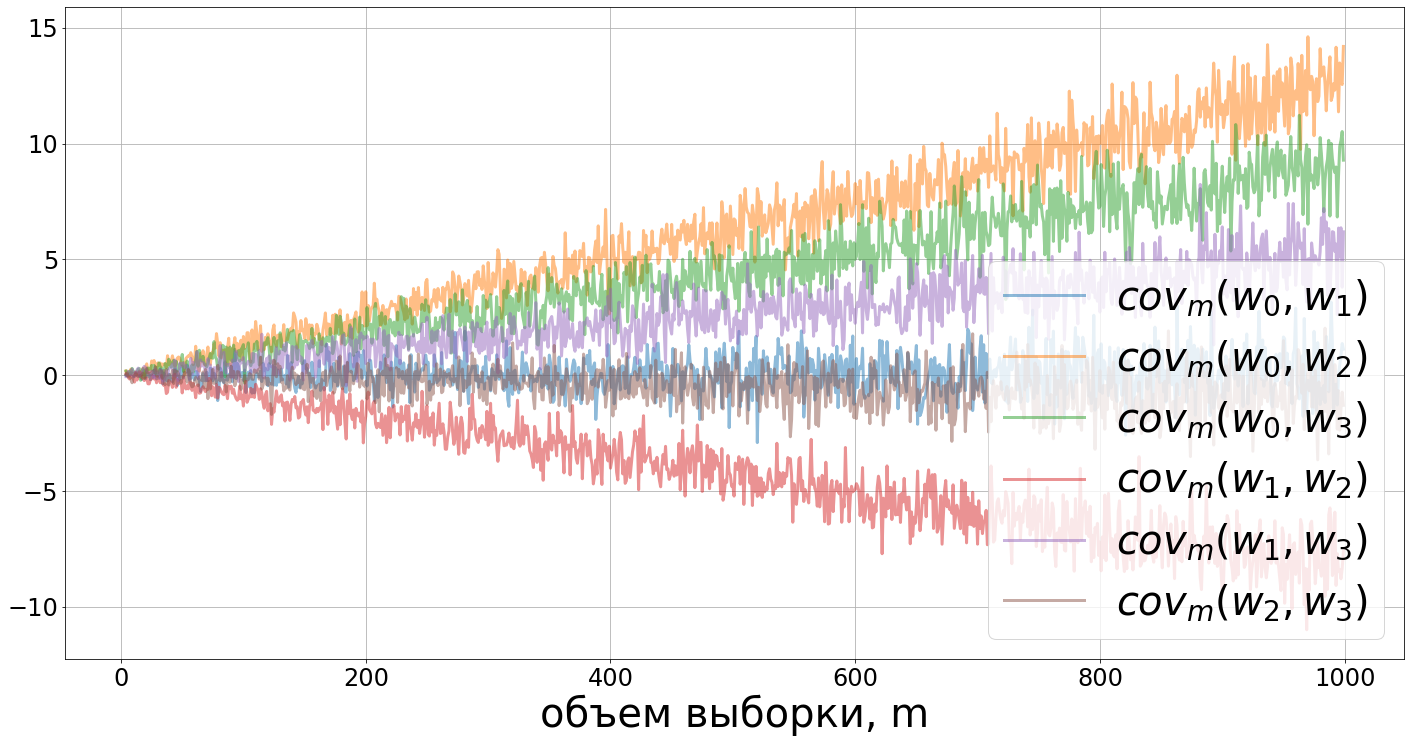

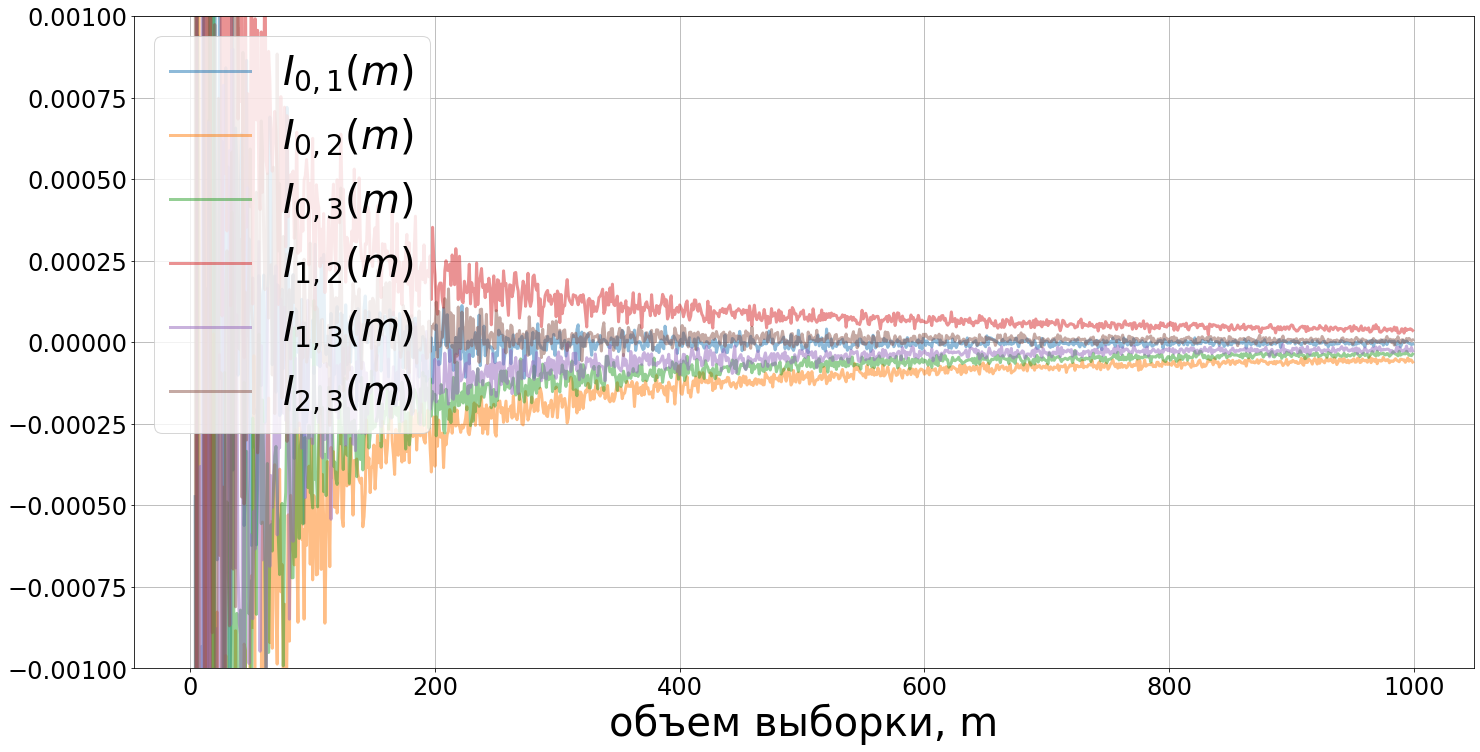

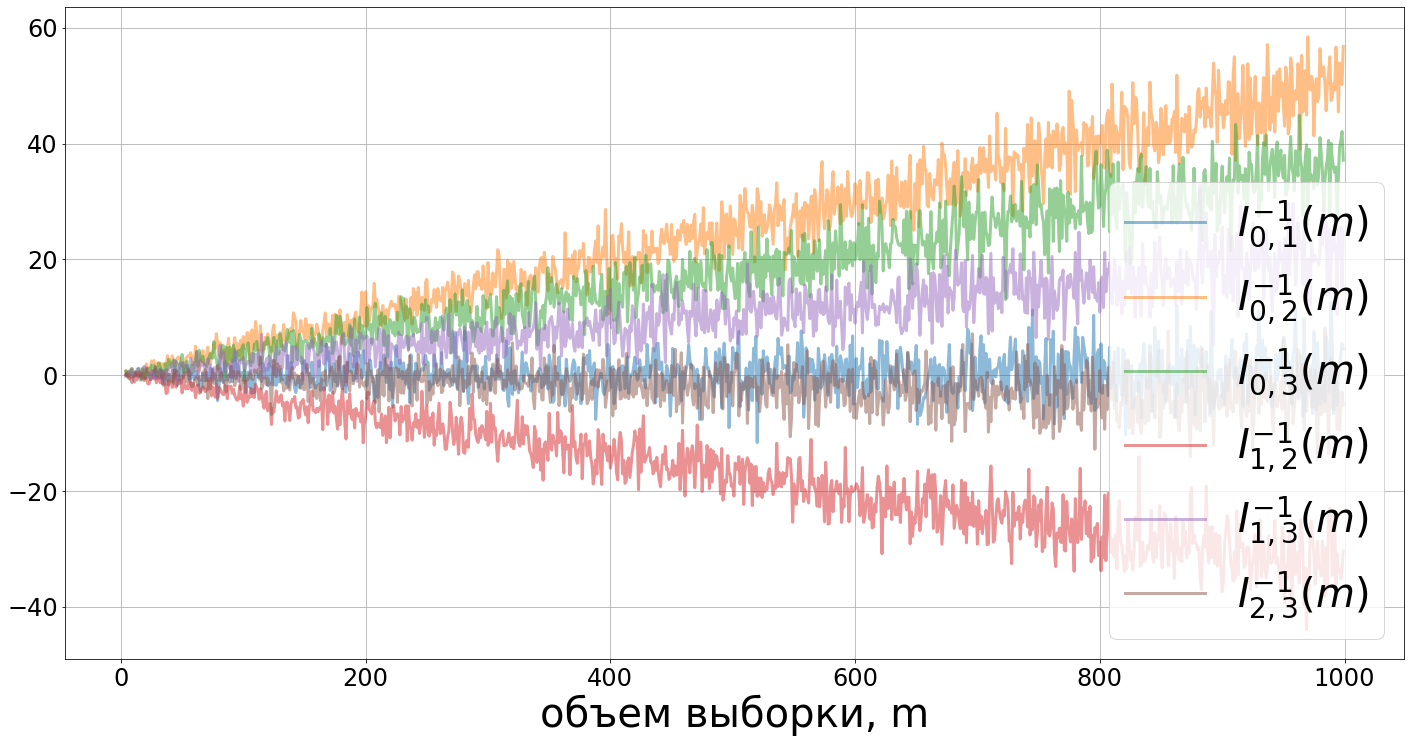

In [101]:
cov = []
I = []

for m in tqdm(range(4, M)):
    
    ans = []
    W = []
    
    for i in range(bootstrap_num_iter):
        idx = np.random.choice(M, size=m)
        
        X_m = X[idx]
        y_m = y[idx]
        
        w_hat = ut.get_params(X_m, y_m)
        
        model = statmodel(y_m, X_m)
        ans.append((-model.hessian_fixed(w_hat)))
        W.append(w_hat.T @ w_hat / n)
#         W.append(w_hat)
    
    W = np.asarray(W)
    ans = np.asarray(ans)
    
#     W -= np.mean(W, axis=0)
#     cov.append(W.T @ W / n / m)
    cov.append(np.mean(ans / n, axis=0))
    
    I.append(np.linalg.inv(np.mean(ans, axis=0)))

cov = np.asarray(cov)
I = np.asarray(I)
    
for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[1]):
        plt.plot(np.arange(4, M), cov[:, i, j], alpha=0.5, label='$cov_m(w_{}, w_{})$'.format(i, j))
        

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid()
plt.savefig('../data/pics/synthetic_W.pdf', format='pdf')
plt.show()

for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[1]):
        plt.plot(np.arange(4, M), I[:, i, j], alpha=0.5, label='$I_{%d, %d}(m)$' % (i, j))
        

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid()
plt.ylim((-0.001, 0.001))
# plt.savefig('../data/pics/synthetic_I.pdf', format='pdf')
plt.show()

I_inv = np.asarray([np.linalg.inv(I[i]) for i in range(I.shape[0])])

for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[1]):
        plt.plot(np.arange(4, M), I_inv[:, i, j], alpha=0.5, label='$I^{-1}_{%d, %d}(m)$' % (i, j))
        

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/synthetic_I.pdf', format='pdf')
plt.show()

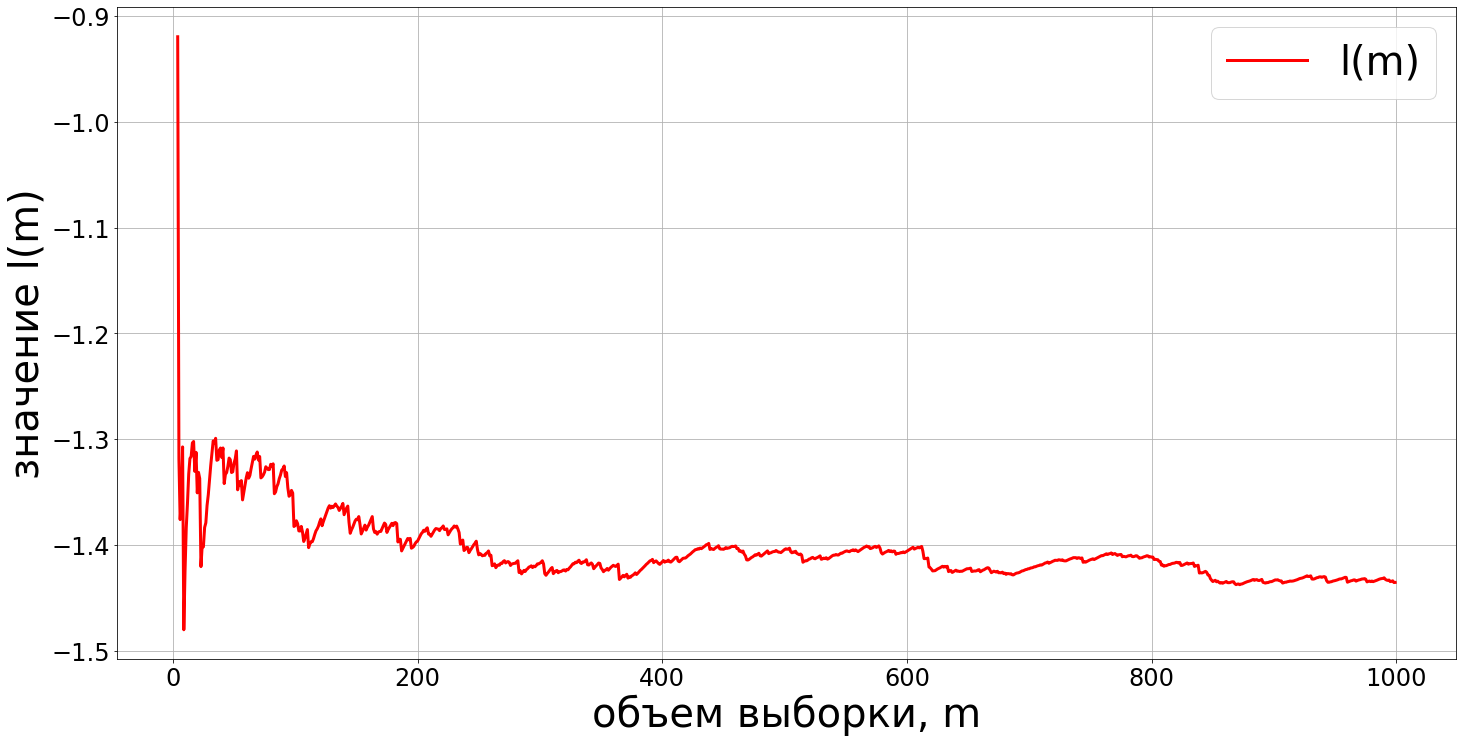

In [7]:
l = []

for m in tqdm(range(4, M)):
    
    X_m, y_m = X[:m], y[:m]
    w_hat = ut.get_params(X_m, y_m)
    
    l.append(np.mean([sps.norm(loc=X @ w_hat, scale=1).logpdf(y) for X, y in zip(X_m, y_m)]))
    
plt.plot(np.arange(4, M), l, color='red', label='l(m)')

plt.xlabel('объем выборки, m')
plt.ylabel('значение l(m)')
plt.legend()
plt.grid()
plt.show()

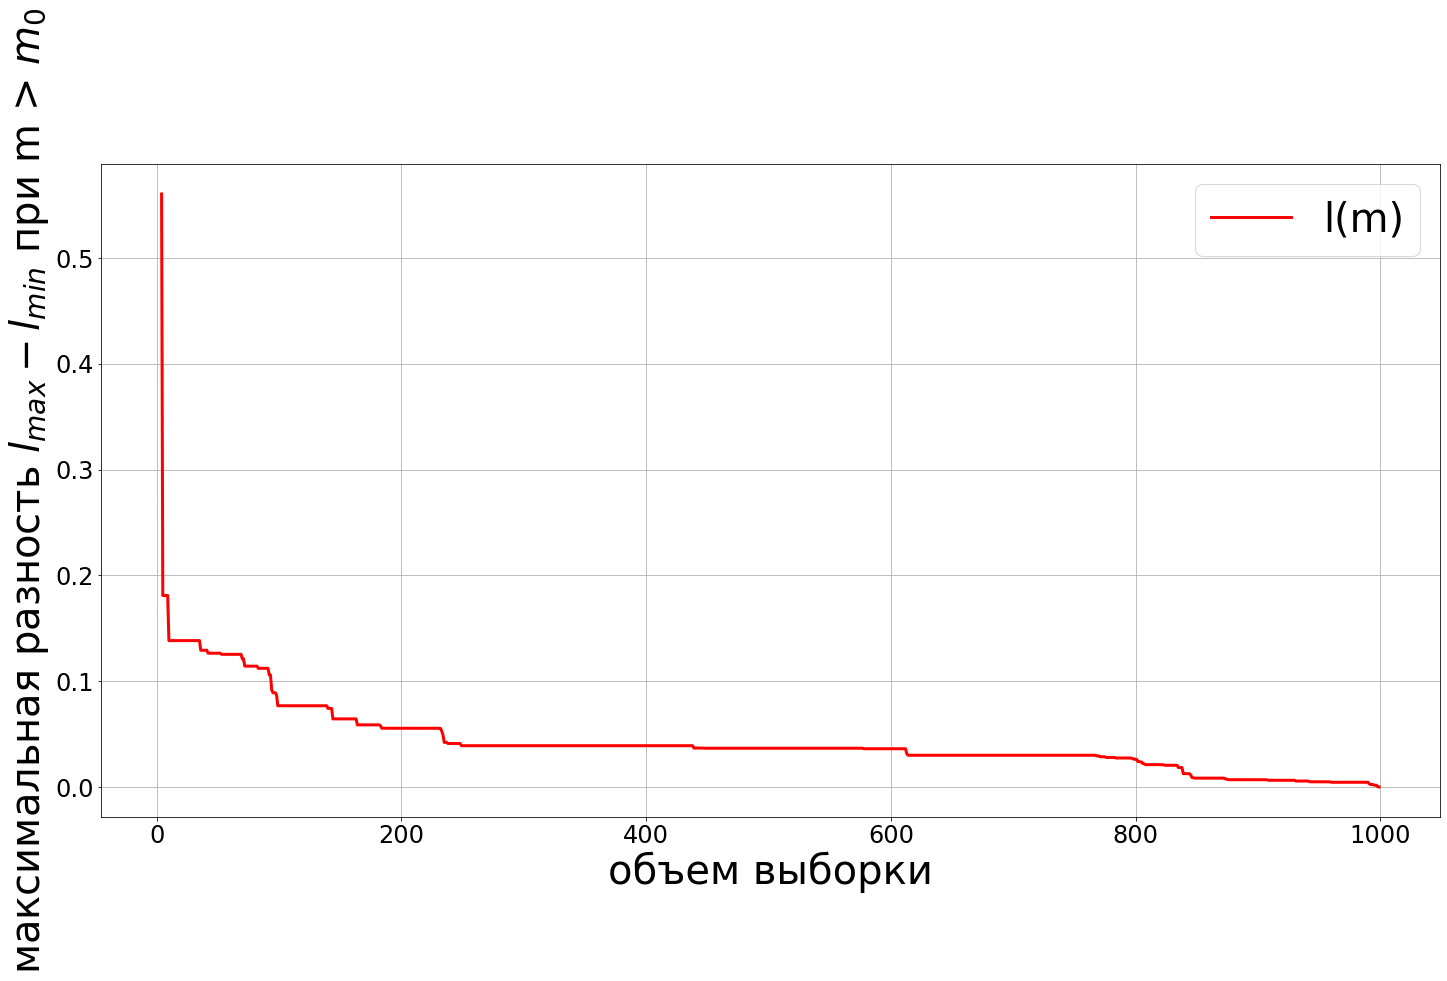

In [8]:
l_diff = []
for i in range(0, len(l)):
    l_diff.append(np.max(l[i:]) - np.min(l[i:]))
    
plt.plot(np.arange(4, X.shape[0]), l_diff, color='red', label='l(m)')

plt.xlabel('объем выборки')
plt.ylabel('максимальная разность $l_{max} - l_{min}$ при m > $m_0$')
plt.legend()
plt.grid()
#plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()

In [54]:
# m_opt = []
eps = 0.1

m_0_max = 100

for m_0 in tqdm(range(4 + len(m_opt), m_0_max + 1)):
    X_m_0, y_m_0 = X[:m_0], y[:m_0]
    w_hat = ut.get_params(X_m_0, y_m_0)

    num_iters = 1000

    answers = []

    for i in range(num_iters):
        X_sub, y_sub = ut.get_subset(X_m_0, y_m_0, m_0 // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))

    answers = np.asarray(answers)

    i_matrix = np.linalg.inv(np.mean(answers, axis=0))

    approx_l = []
    approx_l_std = []

    for m in tqdm(range(m_0 + 1, X.shape[0])):

        cur_l = []

        for i in range(50):
            w_hat_cur = sps.multivariate_normal(mean=w_hat, cov=i_matrix / m).rvs(size=1)
            cur_l.append(np.mean([sps.norm(loc=X @ w_hat_cur, scale=1).logpdf(y) for X, y in zip(X_m_0, y_m_0)]))

        approx_l.append(np.mean(cur_l))
        approx_l_std.append(np.std(cur_l))
    
    left_border = sps.norm(loc=0, scale=approx_l_std).ppf(0.05)
    right_border = sps.norm(loc=0, scale=approx_l_std).ppf(0.95)
        
    m_opt.append(m_0 + 1 + np.argmax((right_border - left_border < eps)))

KeyboardInterrupt: 

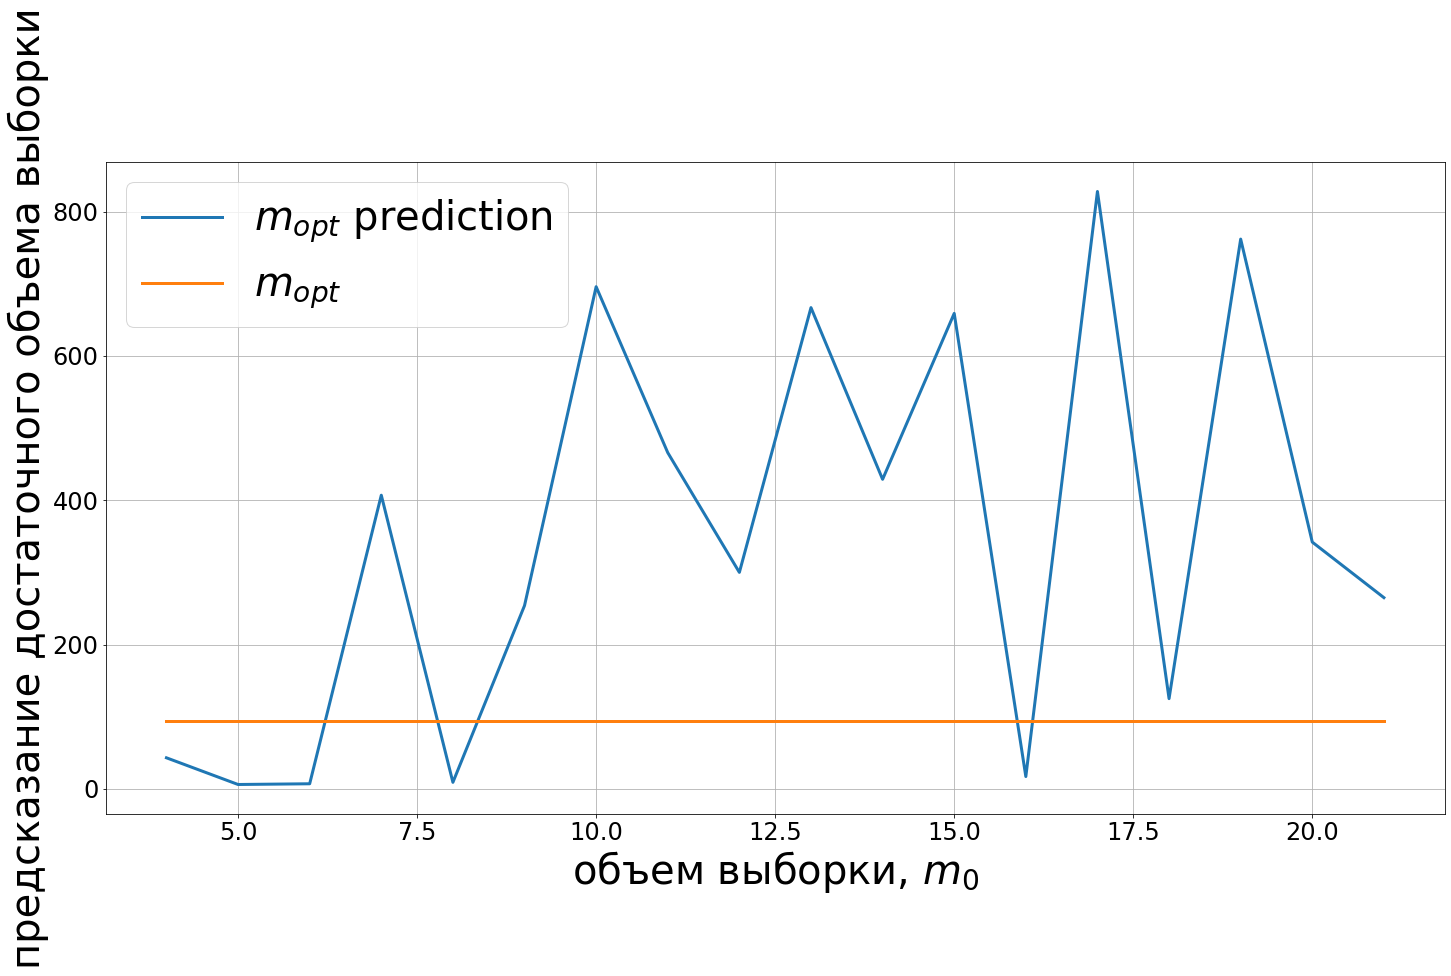

In [53]:
plt.plot(np.arange(4, 4 + len(m_opt)), m_opt, label='$m_{opt}$ prediction')
plt.plot(np.arange(4, 4 + len(m_opt)), np.zeros(len(m_opt)) + 4 + np.argmax(np.array(l_diff) < eps), label='$m_{opt}$')

plt.xlabel('объем выборки, $m_0$')
plt.ylabel('предсказание достаточного объема выборки')
plt.legend()
plt.grid()
plt.savefig('../data/pics/synthetic_approximation_m_opt_interval.pdf', format='pdf')
plt.show()

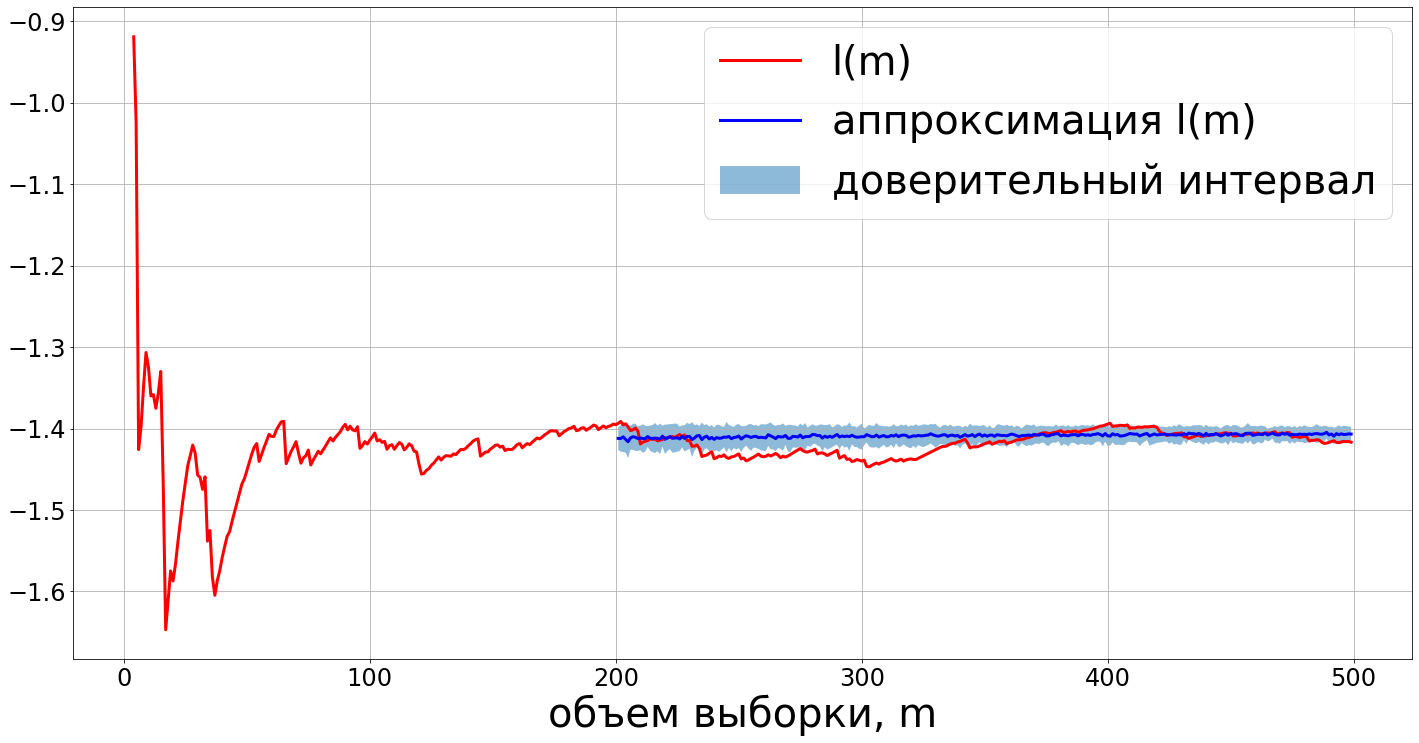

In [64]:
# m_0 = 200

# X_m_0, y_m_0 = X[:m_0], y[:m_0]
# w_hat = ut.get_params(X_m_0, y_m_0)

# num_iters = 1000

# answers = []

# for i in range(num_iters):
#     X_sub, y_sub = ut.get_subset(X_m_0, y_m_0, m_0 // 2, duplications=False)
#     model = statmodel(y_sub, X_sub)
#     w_hat = ut.get_params(X_sub, y_sub)
#     answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))

# answers = np.asarray(answers)

# i_matrix = np.linalg.inv(np.mean(answers, axis=0))

# approx_l = []
# approx_l_std = []

# for m in tqdm(range(m_0 + 1, 500)):

#     cur_l = []

#     for i in range(50):
#         w_hat_cur = sps.multivariate_normal(mean=w_hat, cov=np.linalg.inv(i_matrix) / m).rvs(size=1)
#         cur_l.append(np.mean([sps.norm(loc=X @ w_hat_cur, scale=1).logpdf(y) for X, y in zip(X_m_0, y_m_0)]))

#     approx_l.append(np.mean(cur_l))
#     approx_l_std.append(np.std(cur_l))
    
plt.plot(np.arange(4, 500), l[:496], color='red', label='l(m)')
plt.plot(np.arange(m_0 + 1, 500), approx_l, color='blue', label='аппроксимация l(m)')
plt.fill_between(np.arange(m_0 + 1, 500), sps.norm(loc=approx_l, scale=approx_l_std).ppf(0.05), 
                 sps.norm(loc=approx_l, scale=approx_l_std).ppf(0.95),
                 alpha=0.5, label='доверительный интервал')

plt.xlabel('объем выборки, m')
plt.legend()
plt.grid() 
plt.savefig('../data/pics/synthetic_approximation_l.pdf', format='pdf')
plt.show()